<a href="https://colab.research.google.com/github/LongS1eeper/ML-DL_Prac/blob/%ED%98%BC%EA%B3%B5/%ED%98%BC%EA%B3%B5%EB%A8%B8%EC%8B%A0_09_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM과 GRU 셀

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

## LSTM 신경망 훈련하기

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# pad_sequences로 각 샘플의 길이를 100으로 조작
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [4]:
from tensorflow import keras

model = keras.Sequential()

# 이전 단원의 SimpleRNN을 LSTM으로 바꾼 모델
model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))   # 임베딩 -> 0과 1로 전환
model.add(keras.layers.LSTM(8))    # SimpleRNN(1개)에 비해 작은 셀이 4개가 있으므로 4배 증가한 파라미터 800개
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

# 체크포인트와 중단 설정도 동일
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5864 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5784 - loss: 0.6907 - val_accuracy: 0.6258 - val_loss: 0.6874
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.6217 - loss: 0.6858 - val_accuracy: 0.6562 - val_loss: 0.6765
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6681 - loss: 0.6682 - val_accuracy: 0.7096 - val_loss: 0.6177
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7180 - loss: 0.6006 - val_accuracy: 0.7248 - val_loss: 0.5760
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7404 - val_loss: 0.5555
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7481 - loss: 0.5465 - val_accuracy: 0.7450 - val_loss: 0.5383
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7600 - loss: 0

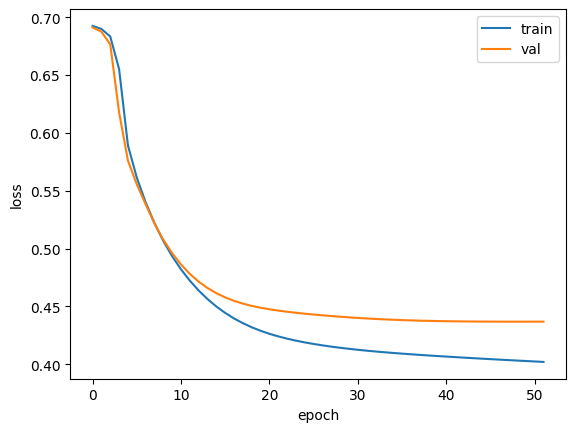

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 순환 층에 드롭아웃 적용하기

In [7]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3))  # 과대적합 방지
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.5145 - loss: 0.6930 - val_accuracy: 0.5716 - val_loss: 0.6922
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.5619 - loss: 0.6920 - val_accuracy: 0.6068 - val_loss: 0.6908
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.6025 - loss: 0.6902 - val_accuracy: 0.6288 - val_loss: 0.6879
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6257 - loss: 0.6865 - val_accuracy: 0.6490 - val_loss: 0.6809
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6458 - loss: 0.6773 - val_accuracy: 0.6560 - val_loss: 0.6494
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6848 - loss: 0.6394 - val_accuracy: 0.7270 - val_loss: 0.5991
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7198 - loss: 0.5997 - val_accuracy: 0.7404 - val_loss: 0.5803
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7326 - loss: 0

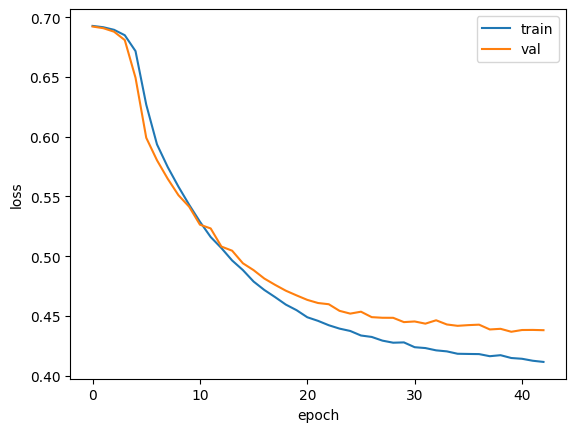

In [9]:
# 드롭아웃의 결과로 훈련 손실과 검증 손실 간의 차이가 좁혀짐
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 2개의 층을 연결하기
* 밀집층과 합성곱 층 처럼 순환층도 여러 개를 쌓을 수 있음
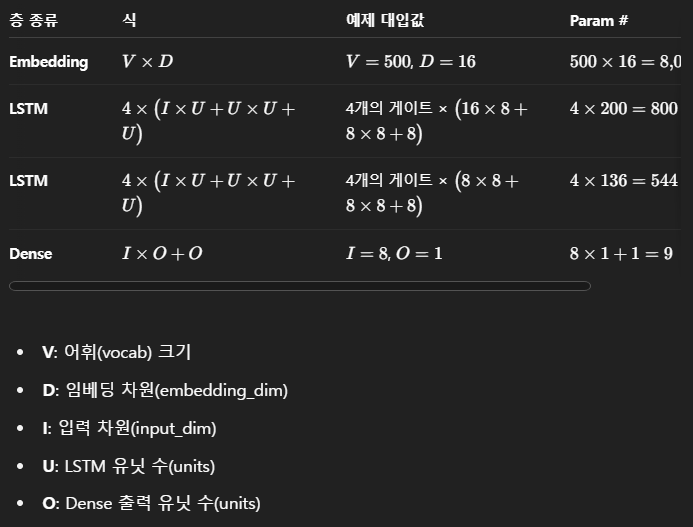

In [10]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))  # 모든 타임스탭의 은닉 상태를 출력하므로 (None, 100, 8)
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 옵티마이저 설정: RMSprop을 학습률 1e-4로 생성
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

# 모델 컴파일: RMSprop, 이진 크로스엔트로피 손실, 정확도 지표
model3.compile(
    optimizer=rmsprop,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 최적 모델 저장: 검증 손실이 개선될 때마다 'best-2rnn-model.keras'에 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-2rnn-model.keras',
    save_best_only=True
)

# 조기 종료: 검증 손실이 연속 3회 개선 없으면 학습 중단, 최적 가중치 복원
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# 모델 훈련: 100 에포크, 배치 크기 64, 검증 데이터와 콜백 적용
history = model3.fit(
    train_seq,               # 패딩된 훈련 시퀀스 (shape: [샘플 수, 시퀀스 길이])
    train_target,            # 훈련 레이블 (0/1)
    epochs=100,              # 최대 에포크 수
    batch_size=64,           # 미니배치 크기
    validation_data=(val_seq, val_target),  # 검증 데이터
    callbacks=[checkpoint_cb, early_stopping_cb]  # 콜백 리스트
)


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.5964 - val_loss: 0.6907
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.5854 - loss: 0.6888 - val_accuracy: 0.6470 - val_loss: 0.6764
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.6495 - loss: 0.6604 - val_accuracy: 0.7104 - val_loss: 0.5774
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.7134 - loss: 0.5717 - val_accuracy: 0.7346 - val_loss: 0.5318
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.7405 - loss: 0.5346 - val_accuracy: 0.7580 - val_loss: 0.5051
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.7571 - loss: 0.5090 - val_accuracy: 0.7616 - val_loss: 0.4972
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.7712 - loss: 0.4930 - val_accuracy: 0.7654 - val_loss: 0.4921
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.7732 - loss: 0

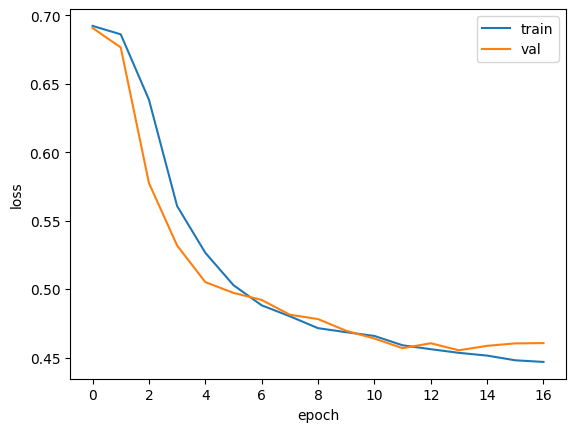

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## GRU 신경망 훈련하기
* GRU 셀

In [13]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model4.add(keras.layers.GRU(8))     # NEW 신경망 층
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5052 - loss: 0.6931 - val_accuracy: 0.5206 - val_loss: 0.6928
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5532 - loss: 0.6925 - val_accuracy: 0.5616 - val_loss: 0.6921
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.5831 - loss: 0.6917 - val_accuracy: 0.5714 - val_loss: 0.6911
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5901 - loss: 0.6903 - val_accuracy: 0.5844 - val_loss: 0.6893
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.6033 - loss: 0.6882 - val_accuracy: 0.5938 - val_loss: 0.6866
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6136 - loss: 0.6849 - val_accuracy: 0.6036 - val_loss: 0.6822
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6197 - loss: 0.6796 - val_accuracy: 0.6120 - val_loss: 0.6752
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.6300 - loss: 0

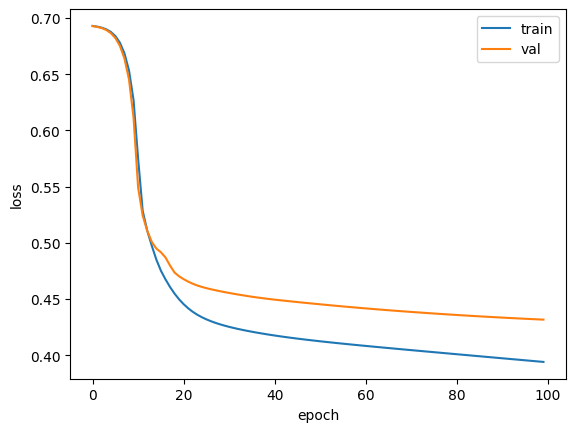

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 마무리

In [16]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.keras')

rnn_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7877 - loss: 0.4545


[0.45431801676750183, 0.7878400087356567]